In [6]:
import pandas as pd
import numpy as np
import warnings; warnings.simplefilter('ignore')

In [5]:
from ucimlrepo import fetch_ucirepo

In [7]:
#Import data
communities_and_crime = fetch_ucirepo(id=183) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 

### Data Preprocessing

In [9]:
#find columns with '?' values
na_columns = X.loc[:, X.isin(["?"]).any()]

In [11]:
#find number of na values in each columns with '?' values
for col in na_columns:
    occurenace = na_columns[col].value_counts().get('?', 0)
    print(col, "has", occurenace, "na values")

county has 1174 na values
community has 1177 na values
OtherPerCap has 1 na values
LemasSwornFT has 1675 na values
LemasSwFTPerPop has 1675 na values
LemasSwFTFieldOps has 1675 na values
LemasSwFTFieldPerPop has 1675 na values
LemasTotalReq has 1675 na values
LemasTotReqPerPop has 1675 na values
PolicReqPerOffic has 1675 na values
PolicPerPop has 1675 na values
RacialMatchCommPol has 1675 na values
PctPolicWhite has 1675 na values
PctPolicBlack has 1675 na values
PctPolicHisp has 1675 na values
PctPolicAsian has 1675 na values
PctPolicMinor has 1675 na values
OfficAssgnDrugUnits has 1675 na values
NumKindsDrugsSeiz has 1675 na values
PolicAveOTWorked has 1675 na values
PolicCars has 1675 na values
PolicOperBudg has 1675 na values
LemasPctPolicOnPatr has 1675 na values
LemasGangUnitDeploy has 1675 na values
PolicBudgPerPop has 1675 na values


In [13]:
#Only 'OtherPerCap' col has one na value, so it is not relevant to remove the whole column.
#So, I will impute missing value with the median for just'OtherPerCap' . 
X['OtherPerCap'] = pd.to_numeric(X['OtherPerCap'].replace('?', np.nan), errors='coerce')

median_OtherPerCap = X['OtherPerCap'].median()
X['OtherPerCap'].fillna(median_OtherPerCap, inplace=True)

In [15]:
#remove na_columns from original datasets and keep 'OtherPerCap' in X
X = X.drop(na_columns, axis=1)
na_columns = na_columns.drop('OtherPerCap', axis=1)

In [17]:
# Check datatype of columns in X 
#'state', 'communityname', and 'fold' are non float datatypes, so remove these columns.
for col in X:
    print(col, "has", X[col].dtypes, "types")

X = X.drop("communityname", axis=1)
X = X.drop("state", axis=1)
X = X.drop("fold", axis=1)

state has int64 types
communityname has object types
fold has int64 types
population has float64 types
householdsize has float64 types
racepctblack has float64 types
racePctWhite has float64 types
racePctAsian has float64 types
racePctHisp has float64 types
agePct12t21 has float64 types
agePct12t29 has float64 types
agePct16t24 has float64 types
agePct65up has float64 types
numbUrban has float64 types
pctUrban has float64 types
medIncome has float64 types
pctWWage has float64 types
pctWFarmSelf has float64 types
pctWInvInc has float64 types
pctWSocSec has float64 types
pctWPubAsst has float64 types
pctWRetire has float64 types
medFamInc has float64 types
perCapInc has float64 types
whitePerCap has float64 types
blackPerCap has float64 types
indianPerCap has float64 types
AsianPerCap has float64 types
HispPerCap has float64 types
NumUnderPov has float64 types
PctPopUnderPov has float64 types
PctLess9thGrade has float64 types
PctNotHSGrad has float64 types
PctBSorMore has float64 types
P

To recap data cleaning, I found columns with '?' values and checked their datatypes. Since they are all object datatypes and contained over 1000 na values except 'OtherPerCap', I removed all columns with '?' values and kept 'OtherPerCap' column by imputing the '?' with median value. Then, I checked the datatypes of the rest of columns in X. 'state', 'fold', and 'communityname' are non float datatypes, so I dropped those three columns. 

# 1

## (a) (i)

### Statistical significance via LEAST SQUARES

In [19]:
import statsmodels.api as sm

In [20]:
#add constant in X
LS_df = sm.add_constant(X)

#fit ls model
LS_model = sm.OLS(y, LS_df).fit()

In [21]:
p_values = LS_model.pvalues
significant_features = p_values[p_values < 0.05].index.tolist()
print("Top features are those with p-value less than 0.05 ", significant_features)

Top features are those with p-value less than 0.05  ['const', 'racepctblack', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWRetire', 'whitePerCap', 'HispPerCap', 'PctPopUnderPov', 'PctEmploy', 'PctEmplManu', 'MalePctNevMarr', 'PctKids2Par', 'PctWorkMom', 'PctIlleg', 'PctNotSpeakEnglWell', 'PersPerOccupHous', 'PersPerRentOccHous', 'PctPersDenseHous', 'HousVacant', 'PctVacantBoarded', 'PctVacMore6Mos', 'RentLowQ', 'MedRent', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet']


### BEST SUBSETS

In [26]:
from sklearn.preprocessing import StandardScaler

# Center data
Y_centered = y - np.mean(y)
X_centered = X - np.mean(X, axis=0)

# Standardize X (centered and scaled)
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

n = X.shape[0]
colnames = X.columns

Perform feature filtering (univariate) for best subset selection

Find the correlation between all predictors (xi,y) for all i, then filter through.
I set k=0.5 because it shrinks variables to a manageable number and keep variables with higher correlations

In [29]:
X_standardized1 = pd.DataFrame(X_standardized, columns=X.columns)
correlations = X_standardized1.corrwith(pd.Series(Y_centered.to_numpy().ravel()))

k = 0.5
selected_features = correlations[abs(correlations) >= k].index

X_filtered = X[selected_features]
#X_filtered now has 15 features

In [12]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LinearRegression

In [33]:
linear_reg = LinearRegression()

#Obtain exhaustive mse values
efs = EFS(
    linear_reg,
    min_features=1, 
    max_features=8,
    scoring="neg_mean_squared_error", #we use negative mse since the sfs method maximizes the score 
    cv=0
)
efs.fit(X_filtered, y)

Features: 3000/22818IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Features: 11802/22818IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Features: 20280/22818IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_win

In [34]:
selected_features = list(efs.best_idx_)
print("Best subset selected features:", X_filtered.columns[selected_features])

Best subset selected features: Index(['racePctWhite', 'PctPopUnderPov', 'MalePctDivorce', 'FemalePctDiv',
       'TotalPctDiv', 'PctFam2Par', 'PctKids2Par', 'PctIlleg'],
      dtype='object')


### STEP-WISE (and/or Recursive Feature Elimination)

In [40]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [42]:
#from Lab5
def calculate_aic(estimator, X, y):
    """
    Custom AIC scorer for SequentialFeatureSelector.
    Args:
        estimator: A fitted sklearn-compatible estimator.
        X: Features (numpy array).
        y: Target variable (numpy array).
    Returns:
        Negative AIC value for compatibility with SFS (higher is better).
    """
    n, k = X.shape  # n: number of samples, k: number of predictors
    y_pred = estimator.predict(X)
    residual_sum_of_squares = np.sum((y - y_pred) ** 2)
    aic = n * np.log(residual_sum_of_squares / n) + 2 * k
    return -aic  # SFS maximizes the score

def aic_scorer_wrapper(estimator, X, y):
    estimator.fit(X, y)
    return calculate_aic(estimator, X, y)

In [44]:
model = LinearRegression()
sfs_forward = SFS(
    model,
    k_features='best',
    forward=True,
    floating=False,
    scoring=aic_scorer_wrapper,  # Use custom AIC scorer
    cv=0  # No cross-validation, evaluate on the whole dataset
)

sfs_forward.fit(X_standardized,Y_centered)
print("Selected features:", np.array(colnames)[np.array(sfs_forward.k_feature_names_, dtype=int)])

Selected features: ['racepctblack' 'racePctWhite' 'racePctHisp' 'agePct12t21' 'agePct12t29'
 'numbUrban' 'pctUrban' 'pctWWage' 'pctWFarmSelf' 'pctWInvInc'
 'pctWSocSec' 'pctWRetire' 'perCapInc' 'whitePerCap' 'blackPerCap'
 'indianPerCap' 'AsianPerCap' 'HispPerCap' 'PctPopUnderPov'
 'PctLess9thGrade' 'PctBSorMore' 'PctEmploy' 'PctEmplManu' 'PctOccupManu'
 'MalePctDivorce' 'MalePctNevMarr' 'TotalPctDiv' 'PctKids2Par'
 'PctWorkMom' 'PctIlleg' 'NumImmig' 'PctSpeakEnglOnly'
 'PctNotSpeakEnglWell' 'PctLargHouseFam' 'PersPerOccupHous'
 'PersPerOwnOccHous' 'PersPerRentOccHous' 'PctPersOwnOccup'
 'PctPersDenseHous' 'PctHousLess3BR' 'HousVacant' 'PctHousOccup'
 'PctVacantBoarded' 'PctVacMore6Mos' 'RentLowQ' 'RentHighQ' 'MedRent'
 'MedRentPctHousInc' 'MedOwnCostPctInc' 'MedOwnCostPctIncNoMtg'
 'NumInShelters' 'NumStreet' 'PctForeignBorn' 'PctUsePubTrans'
 'LemasPctOfficDrugUn']


In [46]:
model = LinearRegression()
sfs_backward = SFS(
    model,
    k_features='best',
    forward=False,
    floating=False,
    scoring=aic_scorer_wrapper,  # Use custom AIC scorer
    cv=0  # No cross-validation, evaluate on the whole dataset
)

sfs_backward.fit(X_standardized,Y_centered)
print("Selected features:", np.array(colnames)[np.array(sfs_backward.k_feature_names_, dtype=int)])

Selected features: ['racepctblack' 'racePctHisp' 'agePct12t29' 'pctUrban' 'pctWWage'
 'pctWFarmSelf' 'pctWInvInc' 'pctWSocSec' 'pctWRetire' 'medFamInc'
 'whitePerCap' 'indianPerCap' 'HispPerCap' 'PctPopUnderPov'
 'PctLess9thGrade' 'PctEmploy' 'PctEmplManu' 'PctOccupManu'
 'PctOccupMgmtProf' 'MalePctDivorce' 'MalePctNevMarr' 'TotalPctDiv'
 'PctKids2Par' 'PctWorkMom' 'NumIlleg' 'PctIlleg' 'NumImmig'
 'PctNotSpeakEnglWell' 'PctLargHouseOccup' 'PersPerOccupHous'
 'PersPerRentOccHous' 'PctPersOwnOccup' 'PctPersDenseHous'
 'PctHousLess3BR' 'MedNumBR' 'HousVacant' 'PctHousOccup' 'PctHousOwnOcc'
 'PctVacantBoarded' 'PctVacMore6Mos' 'OwnOccLowQuart' 'OwnOccMedVal'
 'RentLowQ' 'RentHighQ' 'MedRent' 'MedRentPctHousInc' 'MedOwnCostPctInc'
 'MedOwnCostPctIncNoMtg' 'NumInShelters' 'NumStreet' 'PctForeignBorn'
 'PctUsePubTrans' 'LemasPctOfficDrugUn']


# Lasso

In [52]:
from sklearn.linear_model import Lasso

In [54]:
fit0 = LinearRegression()
fit0.fit(X, y)

lasso = Lasso(alpha=0.01, fit_intercept=False)  
lasso.fit(X, y)

Lasso(alpha=0.01, fit_intercept=False)

In [56]:
important_features = X.columns[lasso.coef_ != 0]
coefs_without_l1 = fit0.coef_.reshape(-1, 1)
coefs_with_l1 = lasso.coef_.reshape(-1, 1)

In [58]:
coef_df = pd.DataFrame(
    np.hstack((X.columns.values.reshape(-1, 1), coefs_without_l1, coefs_with_l1)),
    columns=["Variables", "Without L1", "With L1"]
)
print("Important features selected by Lasso:", list(important_features))

Important features selected by Lasso: ['racepctblack', 'pctUrban', 'pctWPubAsst', 'TotalPctDiv', 'PctIlleg', 'PctPersDenseHous']


In [102]:
import matplotlib.pyplot as plt

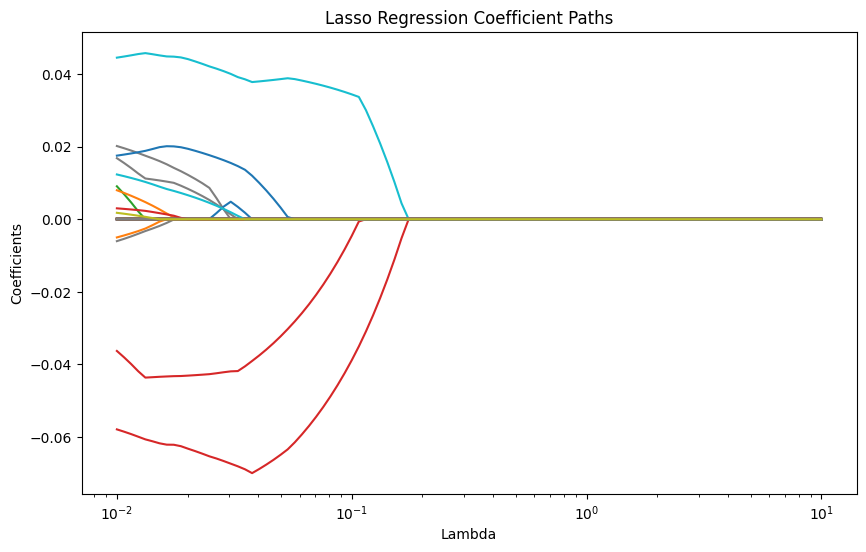

In [104]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
betasl = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    lasso = Lasso(alpha = lamb)
    lasso.fit(X_standardized, Y_centered)
    betasl[i, :] = lasso.coef_

plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]): #for each variable
    plt.plot(lambdas, betasl[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Lasso Regression Coefficient Paths")
#plt.legend(colnames)
plt.show()

# Elastic Net

In [65]:
from sklearn.linear_model import ElasticNet

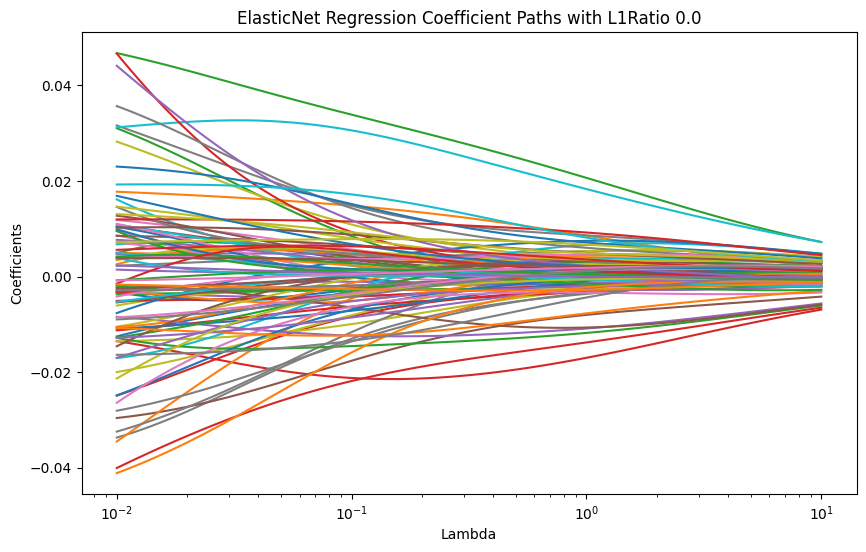

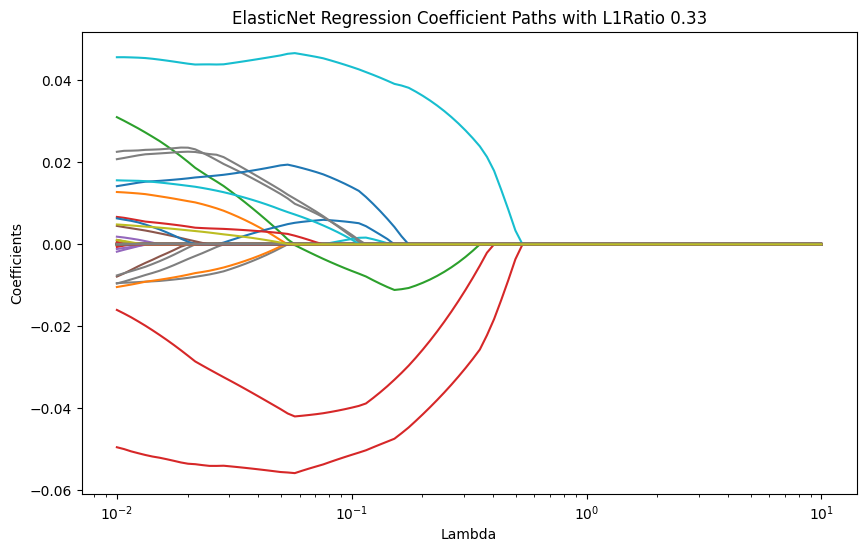

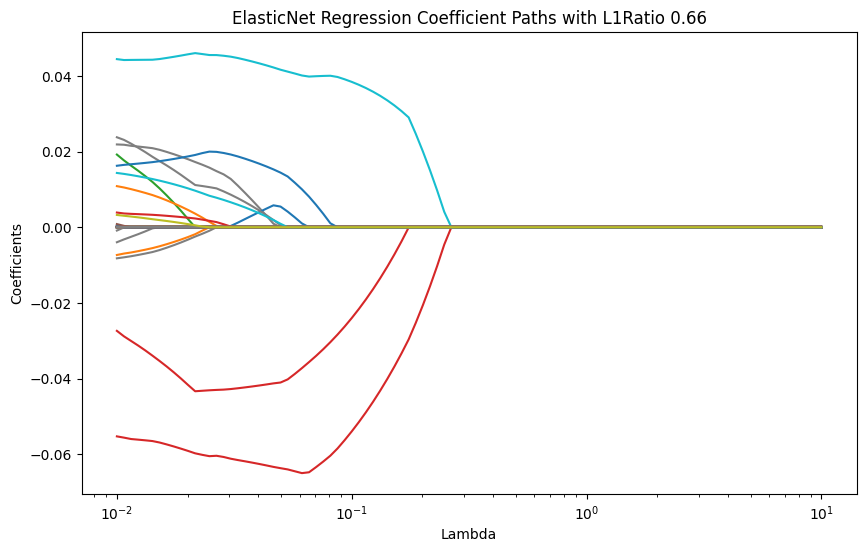

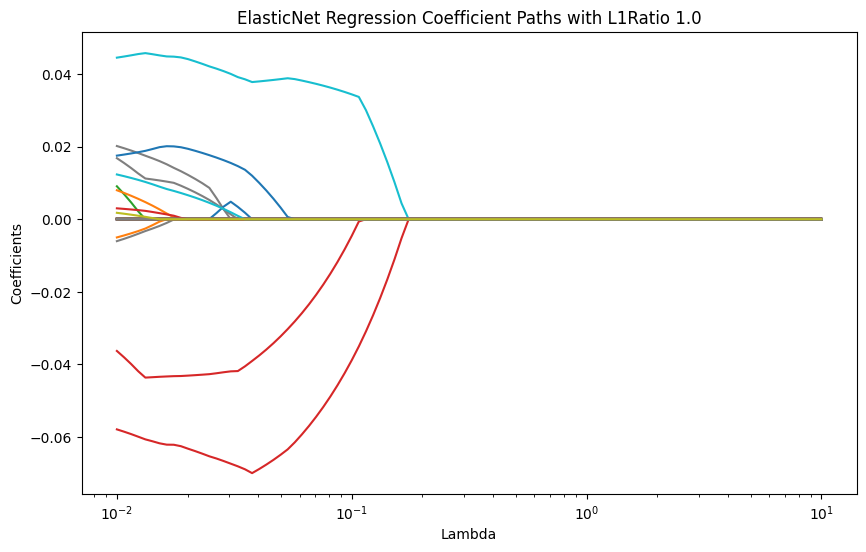

In [69]:
coefs = pd.DataFrame()

lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
l1ratios = np.array([0, 0.33, 0.66, 1])
coefs = pd.DataFrame()
for l1ratio in l1ratios:
    betase = np.zeros((len(lambdas), X.shape[1]))
    for i, lamb in enumerate(lambdas):
        elasticnet = ElasticNet(alpha=lamb, l1_ratio = l1ratio, fit_intercept=False)
        elasticnet.fit(X_standardized, Y_centered)
        betase[i, :] = elasticnet.coef_
        
    plt.figure(figsize=(10, 6))
    for j in range(X_standardized.shape[1]): 
        plt.plot(lambdas, betase[:, j], label=f"Variable {j+1}")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Coefficients")
    plt.title("ElasticNet Regression Coefficient Paths with L1Ratio " + str(l1ratio))
  #  plt.legend(colnames)
    plt.show()
    elasticnet = ElasticNet(alpha=1, l1_ratio = l1ratio, fit_intercept=False)
    elasticnet.fit(X_standardized, Y_centered)
    coefs[l1ratio] = elasticnet.coef_

In [71]:
coefs_df = pd.DataFrame(coefs)
coefs_df.insert(0, 'Variables', colnames)

In [73]:
#Select top 5 features for each l1 ratio
top_5_first = coefs_df.nlargest(5, 0.0) #0.0 l1 ratio
top_5_first['Variables']

2         racepctblack
49            PctIlleg
73    PctVacantBoarded
37      MalePctDivorce
11            pctUrban
Name: Variables, dtype: object

In [75]:
top_5_second = coefs_df.nlargest(5, 0.33) #0.33 l1 ratio
top_5_second['Variables']

0       population
1    householdsize
2     racepctblack
3     racePctWhite
4     racePctAsian
Name: Variables, dtype: object

In [77]:
top_5_third = coefs_df.nlargest(5, 0.66) #0.66 l1 ratio
top_5_third['Variables']

0       population
1    householdsize
2     racepctblack
3     racePctWhite
4     racePctAsian
Name: Variables, dtype: object

In [79]:
top_5_fourth = coefs_df.nlargest(5, 1.0) #1.0 l1 ratio
top_5_fourth['Variables']

0       population
1    householdsize
2     racepctblack
3     racePctWhite
4     racePctAsian
Name: Variables, dtype: object

## ii)

### Ridge

In [98]:
from sklearn.linear_model import Ridge

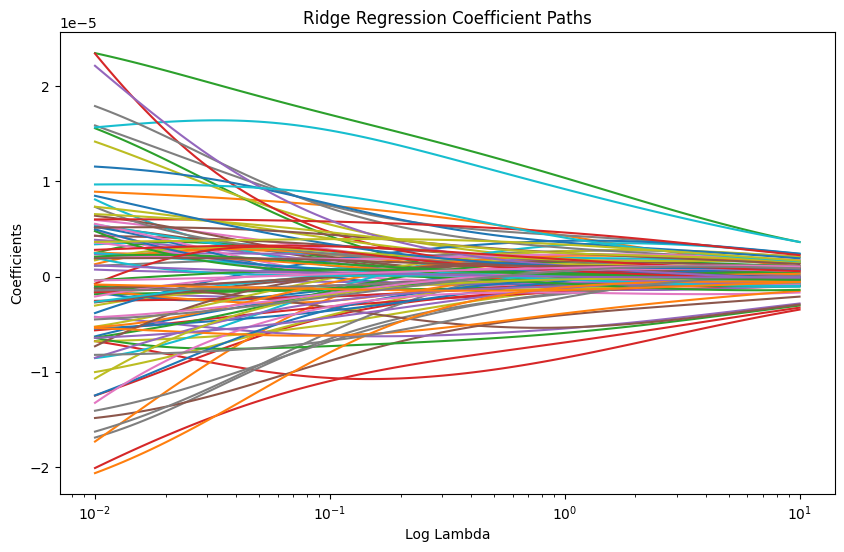

In [100]:
n = X.shape[0] 

lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
betasr = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    betasr[i, :] = (
    np.linalg.inv(X_standardized.T @ X_standardized + np.diag([n * lamb] * X_standardized.shape[1])) 
    @ (X_standardized.T @ Y_centered / n)
    ).to_numpy().ravel()

plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]):
    plt.plot(lambdas, betasr[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Log Lambda")
plt.ylabel("Coefficients")
plt.title("Ridge Regression Coefficient Paths")
plt.show()

# B)

## (i)

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import itertools

### OLS

In [89]:
num_trials = 10
mse_OLS = []

for i in range(num_trials):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=None)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=None)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    mse_OLS.append(test_mse)
    
avg_test_mse = np.mean(mse_OLS)
print(f"Average Test MSE over {num_trials} runs: {avg_test_mse:.4f}")

Average Test MSE over 10 runs: 0.0192


### Ridge

In [91]:
ridge_mses=[]

for i in range(num_trials):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=None)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=None)

    # Hyperparameter tuning for Ridge Regression
    chosen_alpha = None
    chosen_mse = float("inf")
    lambdas = np.logspace(-3, 3, 100)

    for alpha in lambdas:
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(X_train, y_train)
        validation_mse = mean_squared_error(y_val, ridge.predict(X_val))  # Fixed missing parenthesis

        if validation_mse < chosen_mse:
            chosen_mse = validation_mse
            chosen_alpha = alpha

    # Train final Ridge model with best alpha
    ridge_final = Ridge(alpha=chosen_alpha, fit_intercept=False)
    ridge_final.fit(X_train, y_train)

    # Evaluate on the test set
    test_mse = mean_squared_error(y_test, ridge_final.predict(X_test))  # Fixed variable name
    ridge_mses.append(test_mse)

# Report final average test MSE
ridge_avg_mse = np.mean(ridge_mses)
print(f"Average Ridge Regression MSE over {num_trials} runs: {ridge_avg_mse:.4f}")

Average Ridge Regression MSE over 10 runs: 0.0198


### Best Subset

In [93]:
def best_subset_selection(X_train, y_train, X_val, y_val):
    n_features = X_train.shape[1]
    best_mse = float('inf')
    best_features = None

    # Try all subset sizes from 1 to total number of features
    for k in range(1, n_features + 1):
        subsets = combinations(range(n_features), k)
        for subset in subsets:
            X_train_subset = X_train.iloc[:, list(subset)]
            X_val_subset = X_val.iloc[:, list(subset)]
            
            model = LinearRegression()
            model.fit(X_train_subset, y_train)
            y_val_pred = model.predict(X_val_subset)
            mse = mean_squared_error(y_val, y_val_pred)

            if mse < best_mse:
                best_mse = mse
                best_features = subset

    return best_features

In [106]:
best_subset_mses=[]
from itertools import combinations
for _ in range(num_trials):
    
    X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y, test_size=0.4, random_state=np.random.randint(1000))
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=np.random.randint(1000))
    
    best_features = best_subset_selection(X_train, y_train, X_val, y_val)
    
    model = LinearRegression()
    model.fit(X_train.iloc[:, list(best_features)], y_train)
    
    y_test_pred = model.predict(X_test.iloc[:, list(best_features)])
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    best_subset_mses.append(test_mse)
average_test_mse = np.mean(best_subset_mses)
print(average_test_mse)

0.021660343940089432


### Step-Wise

In [440]:
warnings.filterwarnings("ignore")
def calculate_aic(estimator, X, y):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    return model.aic 

def stepwise_fs(X_train, y_train):
    model = LinearRegression()
    sfs = SFS(model, k_features="best", forward=True, floating=True, scoring=calculate_aic, cv=5)
    sfs.fit(X_train, y_train)  # Corrected `.fit()`
    best_features = list(sfs.k_feature_names_)  # Corrected attribute name
    return best_features

In [442]:
stepwise_mse_scores = []
for trial in range(num_trials):
    X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y, test_size=0.4, random_state=None)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=None)

    best_features = stepwise_fs(X_train, y_train) 
    
    if best_features:
        final_model = sm.OLS(y_train, sm.add_constant(X_train[best_features])).fit()
        X_test_subset = sm.add_constant(X_test[best_features], has_constant="add")
        test_mse = mean_squared_error(y_test.to_numpy().flatten(), final_model.predict(X_test_subset))
        stepwise_mse_scores.append(test_mse)  
        
stepwise_avg_mse = np.mean(stepwise_mse_scores)
print(f"Average Stepwise Selection MSE over {num_trials} runs: {stepwise_avg_mse:.4f}")

Average Stepwise Selection MSE over 10 runs: 0.0403


### Lasso

In [445]:
lasso_mses = []

for i in range(num_trials):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=None)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=None)

    chosen_alpha = None
    chosen_mse = float("inf")
    lambdas = np.logspace(-3, 3, 100)  

    for alpha in lambdas:
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)  
        lasso.fit(X_train, y_train)
        validation_mse = mean_squared_error(y_val, lasso.predict(X_val))

        if validation_mse < chosen_mse:
            chosen_mse = validation_mse
            chosen_alpha = alpha

    lasso_final = Lasso(alpha=chosen_alpha, fit_intercept=False, max_iter=10000)
    lasso_final.fit(X_train, y_train)

    test_mse = mean_squared_error(y_test, lasso_final.predict(X_test))
    lasso_mses.append(test_mse)

lasso_avg_mse = np.mean(lasso_mses)
print(f"Average Lasso Regression MSE over {num_trials} runs: {lasso_avg_mse:.4f}")

Average Lasso Regression MSE over 10 runs: 0.0189


### Elastic Net

In [447]:
elastic_mses = []

for i in range(num_trials):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=None)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=None)

    chosen_alpha = None
    chosen_l1_ratio = None
    chosen_mse = float("inf")
    lambdas = np.logspace(-3, 3, 50)  
    l1_ratios = np.linspace(0.1, 0.9, 10)  

    for alpha in lambdas:
        for l1_ratio in l1_ratios:
            elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=False, max_iter=10000)
            elastic.fit(X_train, y_train)
            validation_mse = mean_squared_error(y_val, elastic.predict(X_val))

            if validation_mse < chosen_mse:
                chosen_mse = validation_mse
                chosen_alpha = alpha
                chosen_l1_ratio = l1_ratio

    elastic_final = ElasticNet(alpha=chosen_alpha, l1_ratio=chosen_l1_ratio, fit_intercept=False, max_iter=10000)
    elastic_final.fit(X_train, y_train)

    test_mse = mean_squared_error(y_test, elastic_final.predict(X_test))
    elastic_mses.append(test_mse)

elastic_avg_mse = np.mean(elastic_mses)
print(f"Average Elastic Net Regression MSE over {num_trials} runs: {elastic_avg_mse:.4f}")

Average Elastic Net Regression MSE over 10 runs: 0.0185


## (ii)

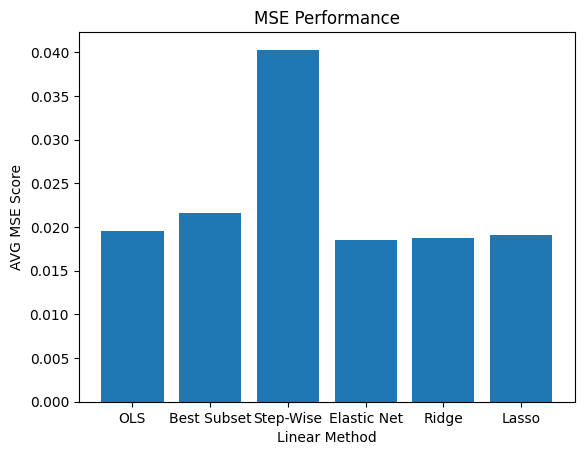

In [109]:
import matplotlib.pyplot as plt
x_axis=['OLS', 'Best Subset', 'Step-Wise', 'Elastic Net', 'Ridge', 'Lasso']
y_axis=[0.0195, 0.02166, 0.0403, 0.0185, 0.0188, 0.0191]

plt.bar(x_axis, y_axis)
plt.title('MSE Performance')
plt.xlabel('Linear Method')
plt.ylabel('AVG MSE Score')
plt.show()

## 2)

## a)

### i)

To empirically demonstrate that fitting linear regression with an intercept term is equivalent to (i) fitting linear regression when centering Y and centering the columns of X, we can create synthetic data with two predictors and a true model with noise. We then fit linear regression model, one with an intercept term and the other with centering X and Y. 

In [8]:
np.random.seed(0)
n = 100
X = np.random.rand(n, 2)  
Y = 2 * X[:, 0] + 3 * X[:, 1] + np.random.normal(0, 1, n)

In [14]:
# Add intercept term
X_with_intercept = np.hstack([np.ones((n, 1)), X])

# Fit model
model_with_intercept = LinearRegression(fit_intercept=False)
model_with_intercept.fit(X_with_intercept, Y)

print("Coefficients with intercept:", model_with_intercept.coef_)

Coefficients with intercept: [0.11450326 1.57370044 3.02957506]


In [16]:
Y_centered = Y - np.mean(Y)
X_centered = X - np.mean(X, axis=0)

model_centered = LinearRegression(fit_intercept=False)
model_centered.fit(X_centered, Y_centered)

print("Coefficients with centered data:", model_centered.coef_)

Coefficients with centered data: [1.57370044 3.02957506]


The coefficients for the non-intercept terms in the two models are be identical, demonstrating the equivalence.

### ii)
To empirically demostrate that fitting linear regression with an intercept term is equivalent to fitting linear regression when adding a column of ones to X, we can similary generate synthetic data with two predictors and a true model with some noise. Then we compare the coefficients of running linear regression model with an intercept term and the case of adding a column of ones to X. 

In [40]:
np.random.seed(0)
n = 100
X = np.random.rand(n, 2)  # Two predictors
Y = 2 * X[:, 0] + 3 * X[:, 1] + np.random.normal(0, 1, n)

In [42]:
model_with_intercept = LinearRegression(fit_intercept=True)
model_with_intercept.fit(X, Y)

print("Intercept (with intercept):", model_with_intercept.intercept_)
print("Coefficients (with intercept):", model_with_intercept.coef_)

Intercept (with intercept): 0.11450325561777985
Coefficients (with intercept): [1.57370044 3.02957506]


In [44]:
X_with_ones = np.hstack([np.ones((n, 1)), X])

model_with_ones = LinearRegression(fit_intercept=False)
model_with_ones.fit(X_with_ones, Y)

print("Coefficients (with column of ones):", model_with_ones.coef_)

Coefficients (with column of ones): [0.11450326 1.57370044 3.02957506]


We see that the intercept and coefficients from both models are the same.

## (b)

To empirically demonstrate the least squares solution has zero training error when p > n, we create a sample data where p is greater than n. We then design matrix, true coefficients and a model with small noise. Lastly, we simply run linear regression model and compute its training error.

In [21]:
n = 20
p = 100  #(p > n)

np.random.seed(0)
X = np.random.randn(n, p)  
beta_true = np.random.randn(p, 1)  
Y = X @ beta_true + np.random.normal(0, 0.1, (n, 1))

In [23]:
model = LinearRegression(fit_intercept=False)
model.fit(X, Y)

Y_pred = model.predict(X)

In [25]:
training_error = np.sum((Y - Y_pred) ** 2)
print("Training Error:", training_error)

Training Error (RSS): 1.6870013866024886e-26


We see that traning error is significantly close to 0 when p > n

## (c)
### (i)

To demonstrate that a least squares estimate has high variance when features are correlated, we can use the Variance Inflation Factor and analyze how it increases significantly when features are highly correlated. 
1. Generate data with varying levels of correlation
2. Fit regression models on both datasets
3. Calculate VIF for each model
4. Compare VIF values
5. High VIF values indicates multicollinearity

In [139]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def generate_data(n_samples=100, correlation=0.9):
    np.random.seed(42)
    X1 = np.random.randn(n_samples, 1)  # Base feature
    X2 = correlation * X1 + np.sqrt(1 - correlation**2) * np.random.randn(n_samples, 1)  # Correlated feature
    
    scaler = StandardScaler()
    X = scaler.fit_transform(np.hstack((X1, X2)))
    
    beta = np.array([[3], [2]])
    
    # generate target variable with noise
    y = X @ beta + np.random.randn(n_samples, 1) * 1.0
    
    return np.hstack((X, y))

In [141]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = ["X1", "X2"]
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data

# generate datasets with high and low correlation
high_corr_data = generate_data(correlation=0.9) #high 
low_corr_data = generate_data(correlation=0.1) #low

# extract features and target variable
X_high, y_high = high_corr_data[:, :-1], high_corr_data[:, -1]
X_low, y_low = low_corr_data[:, :-1], low_corr_data[:, -1]

# compute VIF for both datasets
vif_high = calculate_vif(X_high)
vif_low = calculate_vif(X_low)

In [143]:
model_high = LinearRegression().fit(X_high, y_high)
model_low = LinearRegression().fit(X_low, y_low)

print("VIF for Highly Correlated Features:")
print(vif_high)
print("\nVIF for Weakly Correlated Features:")
print(vif_low)

VIF for Highly Correlated Features:
  Feature       VIF
0      X1  4.411694
1      X2  4.411694

VIF for Weakly Correlated Features:
  Feature       VIF
0      X1  1.001689
1      X2  1.001689


Highly Correlated Features: The VIF values (~4.41) indicate significant multicollinearity. A VIF above 4-5 suggests that the feature's variance is inflated due to correlation with other predictors.

Weakly Correlated Features: The VIF values (~1.00) suggest almost no multicollinearity, meaning the features are nearly independent.

## (ii)

To demonstrate that ridge regression groups highly correlated features for sufficiently large λ, we can fit Ridge models with various lambda values and visualize how the coefficient path will behave when the lambda increases

1. Generate a dataset with correlated features.
2. Fit Ridge models with different λ values.
3. Visualize how the coefficients change as λ increases.
4. Quantify the correlation between the coefficients of correlated features.

In [156]:
np.random.seed(42)
n_samples = 100
X1 = np.random.randn(n_samples)
X2 = X1 + np.random.normal(scale=0.1, size=n_samples)  # Highly correlated with X1
X3 = np.random.randn(n_samples)  # Independent feature
X = np.vstack((X1, X2, X3)).T
y = 3 * X1 + 1.5 * X2 + 2 * X3 + np.random.randn(n_samples) * 0.5

In [158]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge regression with varying λ
lambdas = np.logspace(-3, 3, 50)  # Range of λ values
coefs = []

In [160]:
for l in lambdas:
    ridge = Ridge(alpha=l)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

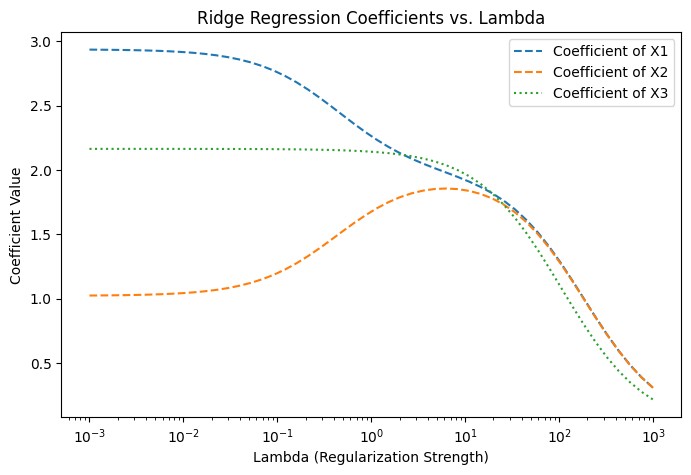

In [162]:
plt.figure(figsize=(8, 5))
plt.plot(lambdas, coefs[:, 0], label="Coefficient of X1", linestyle="dashed")
plt.plot(lambdas, coefs[:, 1], label="Coefficient of X2", linestyle="dashed")
plt.plot(lambdas, coefs[:, 2], label="Coefficient of X3", linestyle="dotted")
plt.xscale("log")
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Ridge Regression Coefficients vs. Lambda")
plt.legend()
plt.show()

At small λ, X1 and X2 have distinct coefficient values.
As λ increases, their coefficients gradually shrink toward each other.
For large λ, the coefficients of X1 and X2 nearly overlap, confirming the grouping effect.

## (iii)

To demonstrate lasso regression selects only one feature from a group of highly correlated features, we can generate a simulated dataset with a set of highly correlated features, apply lasso regression to the data, and observe that the model typically assigns a non-zero coefficient to only one feature from each correlated group, whileeffectively selecting it while setting the others to zero. 
1. Create a set of independent features
2. Generate a target variable that is linearly related to a subset of these features
3. Train a lasso regression model on the simulated data, adjusting the regularization parameter.
4. Examine that within each group of highly correlated features, only one feature usually has a non-zero coefficient, while the others are set to zero. 

In [169]:
np.random.seed(42)
n_samples = 100
n_features = 10

X_independent = np.random.randn(n_samples, n_features // 2)

# Create highly correlated features by adding noise to existing ones
X_correlated = X_independent + np.random.normal(scale=0.01, size=X_independent.shape)

# Combine both sets to form the final dataset
X = np.hstack((X_independent, X_correlated))

# Generate a target variable linearly related to some features
y = 3 * X[:, 0] - 2 * X[:, 1] + 1.5 * X[:, 2] + np.random.normal(scale=0.5, size=n_samples)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.1)  
lasso.fit(X_train_scaled, y_train)

selected_features = np.where(lasso.coef_ != 0)[0]

print("Lasso selected features:", selected_features)
print("Lasso coefficients:", lasso.coef_)

Lasso selected features: [0 1 2 6 7]
Lasso coefficients: [ 2.51851358 -1.82079441  0.76008282  0.          0.          0.
 -0.02805005  0.6103638   0.          0.        ]


Lasso selected the following features with nonzero coefficients:
Feature 0: 𝛽 = 2.5185
Feature 1: 𝛽= −1.8208
Feature 2: 𝛽 = 0.7601
Feature 6: 𝛽=−0.0281
Feature 7: 𝛽 = 0.6104
Meanwhile, the other features were assigned a coefficient of zero, meaning that Lasso effectively removed them from the model.